In [3]:
import numpy as np
np.set_printoptions(suppress=True)
import glob
import matplotlib.pyplot as plt
from skimage import color
from skimage.transform import resize
import time
import models
import pca
import skimage

### Loading training & testing data

In [4]:
def load_data(path):
    #get filenames and total
    normal_filenames=glob.glob("../data/"+path+"/normal/*")
    pneumonia_filenames=glob.glob("../data/"+path+"/pneumonia/*")
    total=len(normal_filenames)+len(pneumonia_filenames)
    #arrays to store data
    x=np.ones((total,64*64))
    y=np.ones((total,))
    
    #load normal images belonging to class 0
    i=0
    for filename in normal_filenames:
        image=plt.imread(filename)
        if image.ndim>2:
            image=image[:,:,0]
        x[i,:]=image.flatten()
        y[i]=0
        i=i+1
    
    #load pneumonia images belonging to class 1
    for filename in pneumonia_filenames:
        image=plt.imread(filename)
        if image.ndim>2:
            image=image[:,:,0]
        x[i,:]=image.flatten()
        y[i]=1
        i=i+1
    
    idx=np.arange(len(x))
    np.random.shuffle(idx)
    x=x[idx]
    y=y[idx]

    return x,y


In [6]:
x_train,y_train=load_data("train")
x_test,y_test=load_data("test")

### Principal component analysis

Number of components for 90% variation  69


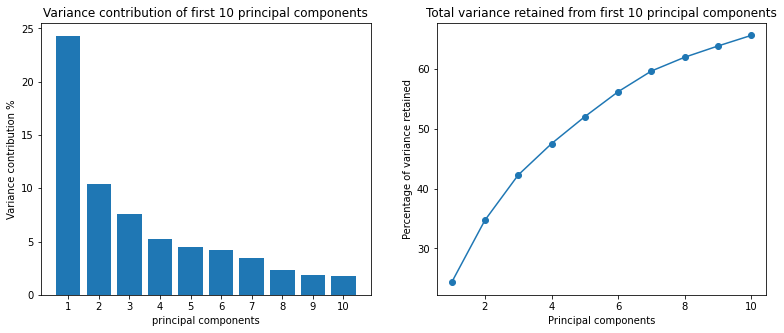

In [7]:
principal_component_analysis=pca.principal_components(x_train)
variances=principal_component_analysis.variance_contributions()[:10]
components=1+np.arange(len(variances))


fig,axis=plt.subplots(1,2,figsize=(13,5))

axis[0].set(xlabel="principal components",ylabel="Variance contribution %",
            title="Variance contribution of first 10 principal components")
axis[0].bar(components.astype(str),variances*100)

cumulative_variances=np.cumsum(variances)

axis[1].set(xlabel="Principal components",ylabel="Percentage of variance retained",
            title="Total variance retained from first 10 principal components")
axis[1].scatter(components,cumulative_variances*100)
axis[1].plot(components,cumulative_variances*100)
d=principal_component_analysis.variation(0.9)
print("Number of components for 90% variation ",d)

### Dimensionality reduction

In [8]:
x_train_pca=principal_component_analysis.d_principal_components(x_train,d)
x_test_pca=principal_component_analysis.d_principal_components(x_test,d)

### Augment bias term as ones

In [9]:
def add_bias(x):
    bias=np.ones((x.shape[0],1))
    x=np.hstack((bias,x))
    return x

### Normalization parameters

In [10]:
def normalization_parameters(x):
    mean=np.mean(x,axis=0)
    std=np.std(x,axis=0)
    return mean,std

### Normalize data

In [11]:
mean,std=normalization_parameters(x_train_pca)
x_train_pca=(x_train_pca-mean)/(std+10**-4) #avoid zero division
x_test_pca=(x_test_pca-mean)/(std+10**-4)
x_train_pca=add_bias(x_train_pca)
x_test_pca=add_bias(x_test_pca)

## Model fitting

### $k$-NN

Training errors: {'3-NN': 0.023, '5-NN': 0.028, '7-NN': 0.029, '9-NN': 0.027, '11-NN': 0.028, '13-NN': 0.03}
Training accuracy 3-NN 97.74688398849473
Testing accuracy 3-NN 84.3452380952381
Computation time for testing in seconds 2.59


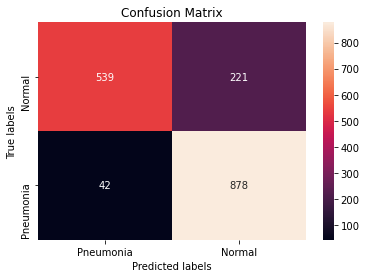

In [12]:
errors={}
K=np.arange(3,15,2)
perfomance=[]
for k in K:
    knn=models.kNN(x_train_pca,y_train,k)
    perfomance=(knn.training_fit())
    errors[str(k)+"-NN"]=np.round(1-perfomance,3)
    
print("Training errors:",errors)
knn=models.kNN(x_train_pca,y_train,3)

print("Training accuracy 3-NN",100*knn.training_fit())
start=time.time()
print("Testing accuracy 3-NN",100*knn.testing_fit(x_test_pca,y_test))
end=time.time()
print("Computation time for testing in seconds",round(end-start,2))
knn.confusion_matrix(x_test_pca,y_test)
#plt.savefig("knn-matrix.png")

## Logistic regression

### Gradient descent learning

Random parameters training accuracy 39.9568552253116 %


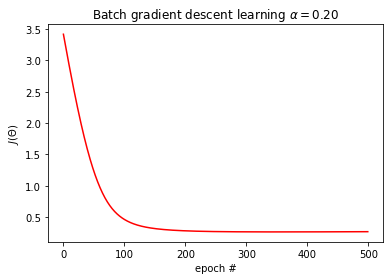

Training accuracy: 97.12368168744008 %

Learning time 0.9558815956115723 seconds

Testing accuracy: 85.11904761904762 %



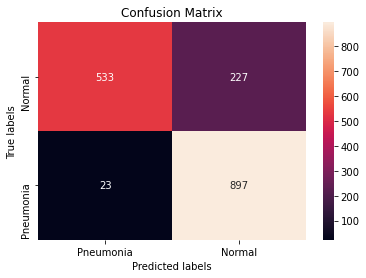

In [13]:
lr=models.logistic_regression(x_train_pca,y_train)
alpha=0.2
epsilon=10**-4
t_max=500

print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
lr.train_model(mode="bgd",alpha=alpha,epsilon=epsilon,t_max=t_max)
end=time.time()
J1=lr.J

plt.figure()
plt.plot(np.arange(len(J1)), J1,c="r")
plt.xlabel('epoch #')
plt.ylabel(r'$J(\Theta)$')
plt.title(r'Batch gradient descent learning $\alpha={:.2f}$'.format(alpha))
#plt.savefig("batch.png")
plt.show()

print("Training accuracy:",lr.training_fit()*100,"%\n")
print("Learning time",end-start,"seconds\n")
print("Testing accuracy:",lr.testing_fit(x_test_pca,y_test)*100,"%\n")
lr.confusion_matrix(x_test_pca,y_test)
#plt.savefig("lr-matrix.png")

Random parameters training accuracy 46.42857142857143 %


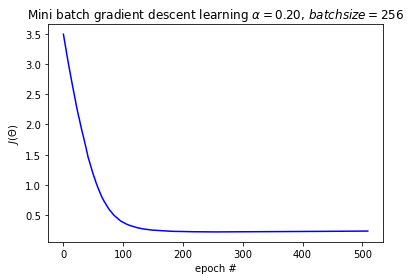

Training accuracy: 97.02780441035475 %

Learning time 0.8958261013031006 seconds

Testing accuracy: 85.77380952380952 %



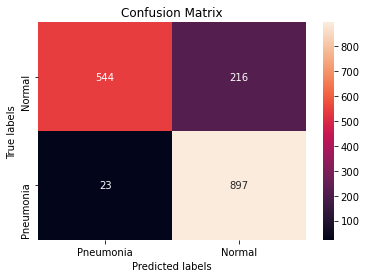

In [14]:
lr=models.logistic_regression(x_train_pca,y_train)
batch_size=256
print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
lr.train_model(mode="mbgd",alpha=alpha,epsilon=epsilon,batch_size=batch_size,t_max=t_max)
end=time.time()
J1=lr.J
plt.figure()
plt.plot(np.arange(len(J1)), J1,c="b")
plt.xlabel('epoch #')
plt.ylabel(r'$J(\Theta)$')
plt.title(r'Mini batch gradient descent learning $\alpha={:.2f}$, $batch size=${:}'.format(alpha,batch_size))
#plt.savefig("mini-batch.png")
plt.show()

print("Training accuracy:",lr.training_fit()*100,"%\n")
print("Learning time",end-start,"seconds\n")
print("Testing accuracy:",lr.testing_fit(x_test_pca,y_test)*100,"%\n")
lr.confusion_matrix(x_test_pca,y_test)

Random parameters training accuracy 46.236816874400766 %


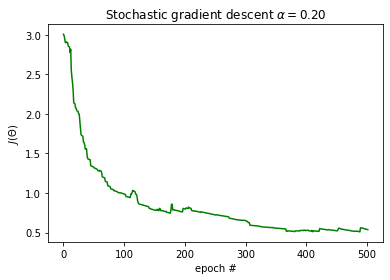

Training accuracy: 91.65867689357621 %

Learning time 0.6862132549285889 seconds

Testing accuracy: 82.61904761904762 %



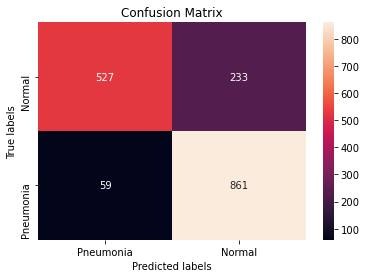

In [18]:
lr=models.logistic_regression(x_train_pca,y_train)
print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
lr.train_model(mode="sgd",alpha=alpha,epsilon=epsilon,t_max=t_max)
end=time.time()
J1=lr.J
plt.figure()
plt.plot(np.arange(len(J1)), J1,c="g")
plt.xlabel('epoch #')

plt.ylabel(r'$J(\Theta)$')
plt.title(r'Stochastic gradient descent $\alpha={:.2f}$'.format(alpha))
#plt.savefig("stochastic.png")
plt.show()

print("Training accuracy:",lr.training_fit()*100,"%\n")
print("Learning time",end-start,"seconds\n")
print("Testing accuracy:",lr.testing_fit(x_test_pca,y_test)*100,"%\n")
lr.confusion_matrix(x_test_pca,y_test)

### Genetic algorithm learning

Random parameters training accuracy 50.45541706615532 %


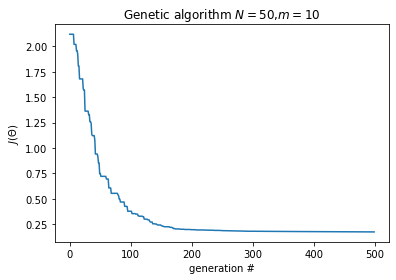

Training accuracy: 93.86385426653882 %

Learning time 9.558348178863525 seconds

Testing accuracy: 84.10714285714286 %



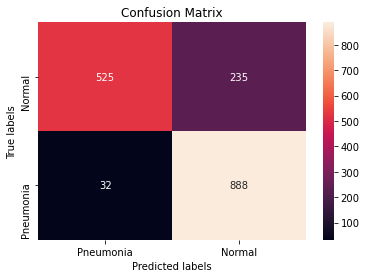

In [19]:
lr=models.logistic_regression(x_train_pca,y_train)
print("Random parameters training accuracy",lr.training_fit()*100,"%")
start=time.time()
N=50
m=10
lr.train_model(mode="ga",t_max=t_max,N=N,m=m)
end=time.time()
J1=lr.J
plt.figure()
plt.plot(np.arange(len(J1)), J1)
plt.xlabel('generation #')
plt.ylabel(r'$J(\Theta)$')
plt.title(r'Genetic algorithm $N={:}$,$m={:}$'.format(N,m))
plt.show()
print("Training accuracy:",lr.training_fit()*100,"%\n")
print("Learning time",end-start,"seconds\n")
print("Testing accuracy:",lr.testing_fit(x_test_pca,y_test)*100,"%\n")
lr.confusion_matrix(x_test_pca,y_test)
#plt.savefig("lr-g-matrix.png")

### Multi layer perceptron

Training accuracy 99.73633748801534 

Learning time 0.0031919479370117188 seconds

Testing accuracy 86.30952380952381 



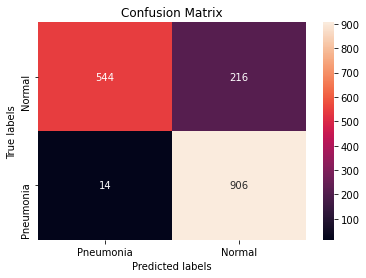

In [20]:
mp=models.multilayer_perceptron(x_train_pca,y_train,(34),solver="sgd",learning_rate=0.02)
mp.train_model()
start=time.time()
print("Training accuracy",mp.training_fit()*100,"\n")
end=time.time()
print("Learning time",end-start,"seconds\n")
print("Testing accuracy",mp.testing_fit(x_test_pca,y_test)*100,"\n")
mp.confusion_matrix(x_test_pca,y_test)
#plt.savefig("mp-matrix.png")